<a href="https://colab.research.google.com/github/AanchalA/MakeMore-with-Andrej-Karpathy/blob/main/MakeMoreNames_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F

import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
! wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-04-29 11:13:12--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.004s  

2023-04-29 11:13:12 (55.3 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
words = open('names.txt').read().splitlines()
len(words)

32033

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
# stoi['<S>'] = 26
# stoi['<E>'] = 27
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)

# Building the Dataset

In [ ]:
# HyperParameters

EPOCHS = 1000
BLOCK_SIZE = 3              ## Context Length: how many characters do we take to predict the next one?
BATCH_SIZE = 32
EMBEDDINGS_DIM = 2
LEARNING_RATE = 0.1
NUM_HIDDEN_UNITS = 100

In [ ]:
X, Y = list(), list()

for w in words:

    # print(f"\nNAME: {w}")
    context = [0] * BLOCK_SIZE      ## [0, 0, 0]
    for ch in w + '.':              ## Appending '.' at the end of the name
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)

        # print('\t', ''.join(itos[i] for i in context), '--->', itos[ix])

        context = context[1:] + [ix]            ## POP from the top and then append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, X.dtype, Y.shape, Y.dtype          ## 32 Examples from 5 names

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
mini_batch = torch.randint(0, X.shape[0], (BATCH_SIZE,))             ## Creating mini batch of random indexes b/w 0 and num_samples
mini_batch

tensor([106966, 106379, 197295,   3049, 186033, 216007, 134553, 164312, 174376,
         77964, 162529, 129389,   3850, 137178, 221574, 171970,  48813, 164477,
        209629,  89509, 133392, 134533, 125263, 109590,   5667,  68622, 222339,
         32550,   4488,  35069, 185089,   8864])

# Parameter Initilization

In [ ]:
g = torch.Generator().manual_seed(2147483647)

## Character Embeddings

In [ ]:
C = torch.randn((vocab_size, EMBEDDINGS_DIM), generator=g)     ## C: Embedding Layer - 2 dim embedding vec for each of 27 characters
C.shape

torch.Size([27, 10])

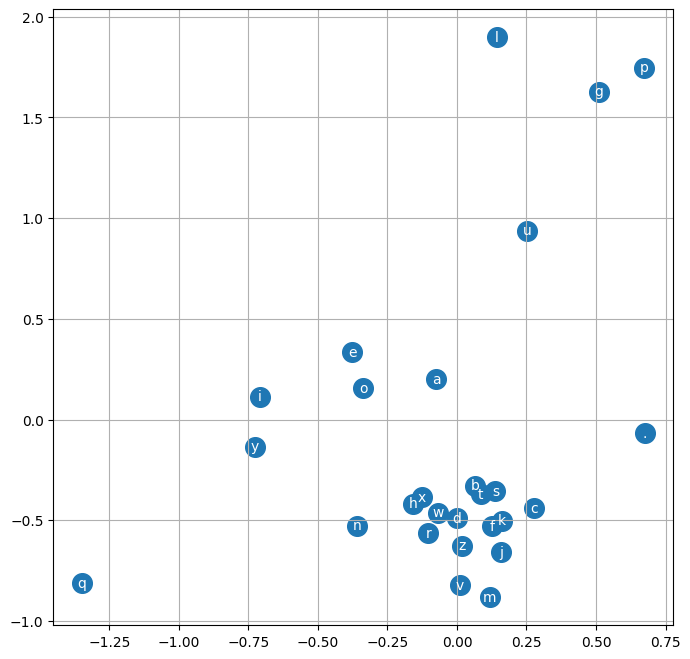

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
emb = C[X]                                                    ## Getting the embedding encoding for all datapoints in X [0, 0, 0] --> [[0.2, 0.3], [0.2, 0.3], [0.2, 0.3]]
emb.shape

torch.Size([32, 3, 10])

In [ ]:
emb = emb.view(-1, (BLOCK_SIZE * EMBEDDINGS_DIM))               ## Reshape emb=[n_examples, 3, 2] to emb=[n_examples, 3*2]
emb.shape

torch.Size([32, 30])

## Other Parameters

In [ ]:
W1 = torch.randn((BLOCK_SIZE * EMBEDDINGS_DIM, NUM_HIDDEN_UNITS), generator=g)
b1 = torch.randn(NUM_HIDDEN_UNITS, generator=g)
W1.shape, b1.shape

(torch.Size([30, 200]), torch.Size([200]))

In [ ]:
W2 = torch.randn((NUM_HIDDEN_UNITS, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
W2.shape, b2.shape

(torch.Size([200, 27]), torch.Size([27]))

In [ ]:
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters)          ## Total number of parameters

11897

In [ ]:
for p in parameters:
    p.requires_grad = True              ## setting  requires_grad = True for leaf nodes

# Forward Pass

In [ ]:
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2                    ## logits -- Interpreted as "log-Counts/log-frequency" of each block

# ### All of this is basically --> CROSS ENTROPY == Average Negtive Log Likelihood
# count = logits.exp()
# prob = count / count.sum(1, keepdims=True)
# loss = -prob[torch.arange(X.shape[0]), Y].log().mean()          # mean of log likelihood (sum of log of the current probabilities of the actual Label)
# loss

In [ ]:
loss = F.cross_entropy(logits, Y)
loss

tensor(29.6480, grad_fn=<NllLossBackward0>)

# Backward Pass

In [ ]:
for p in parameters:
    p.grad = None

loss.backward()

# Learning Rate Scheduler

In [ ]:
lrs = torch.linspace(0.001, 1, steps=1000)                    ## We do not want to step b/w the distribution linearly. We want to step exponantly

In [ ]:
10 ** -3, 10 ** 0

(0.001, 1)

In [ ]:
lre = torch.linspace(-3, 0, steps=1000)                     ## Since we are taking the exponents we take -3, 0 instead of 0.01, 1 as 10^-3 = 0.001 and 10^0 = 1
lrs = 10 ** lre                                             ## Now we are spaced exponentially in this interval
# lrs

# Parameter Update

In [ ]:
# for p in parameters:
#     p.data += -LEARNING_RATE * p.grad                   ## ERROR: Grad for C is not being calculated in loss.backward()

# Putting Everything Together

In [ ]:
# HyperParameters

EPOCHS = 200000
BLOCK_SIZE = 3              ## Context Length: how many characters do we take to predict the next one?
BATCH_SIZE = 64
EMBEDDINGS_DIM = 10
LEARNING_RATE = 0.1
NUM_HIDDEN_UNITS = 200
LEARNING_RATE_DECAY = 0.01

In [ ]:
def build_dataset(words):

    X, Y = list(), list()

    for w in words:

        # print(f"\nNAME: {w}")
        context = [0] * BLOCK_SIZE      ## [0, 0, 0]
        for ch in w + '.':              ## Appending '.' at the end of the name
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            # print('\t', ''.join(itos[i] for i in context), '--->', itos[ix])

            context = context[1:] + [ix]            ## POP from the top and then append

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)

    return X, Y

In [ ]:
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])                # 80%
Xdev, Ydev = build_dataset(words[n1:n2])            # 10%
Xte, Yte = build_dataset(words[n2:])                # 10%

torch.Size([182424, 3]) torch.Size([182424])
torch.Size([22836, 3]) torch.Size([22836])
torch.Size([22886, 3]) torch.Size([22886])


In [ ]:
g = torch.Generator().manual_seed(2147483647)                   # for reproducibility

C = torch.randn((vocab_size, EMBEDDINGS_DIM), generator=g)
W1 = torch.randn((BLOCK_SIZE * EMBEDDINGS_DIM, NUM_HIDDEN_UNITS), generator=g)
b1 = torch.randn(NUM_HIDDEN_UNITS, generator=g)
W2 = torch.randn((NUM_HIDDEN_UNITS, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [ ]:
lr_i = list()
loss_i = list()
step_i = list()

In [ ]:
for i in tqdm(range(EPOCHS)):

    ## Mini-Batch
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))


    ## Forward Pass
    emb = C[Xtr[ix]]          ## Indexing X for only the selected indexes in the mini-batch
    emb = emb.view(-1, BLOCK_SIZE * EMBEDDINGS_DIM)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])


    ## Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()


    ## Parameter Update
    # lr = lrs[i]          ## Learning rate scheduler
    lr = LEARNING_RATE if i < (EPOCHS / 2) else LEARNING_RATE_DECAY

    for p in parameters:
        p.data += -lr * p.grad


    ## Track Stats
    ## lr_i.append(lr)
    # lr_i.append(lre[i])         ## Taking the exponent instead of the learning rate
    step_i.append(i)
    loss_i.append(loss.log10().item())

print(f"\n\n LOSS: {loss.item()}")

100%|██████████| 200000/200000 [01:50<00:00, 1803.63it/s]



 LOSS: 2.08046555519104


In [ ]:
# Model Evaluation using Train set

emb = C[Xtr]
emb = emb.view(-1, BLOCK_SIZE * EMBEDDINGS_DIM)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)

print(f"LOSS: {loss.item()}")

LOSS: 2.1184492111206055


In [ ]:
# Model Evaluation using Dev set

emb = C[Xdev]
emb = emb.view(-1, BLOCK_SIZE * EMBEDDINGS_DIM)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)

print(f"LOSS: {loss.item()}")

LOSS: 2.160029411315918


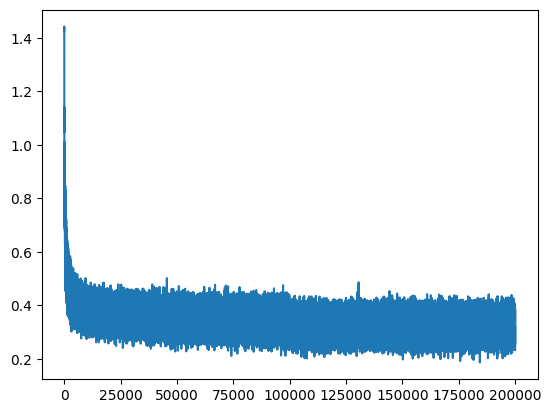

In [ ]:
plt.plot(step_i, loss_i)

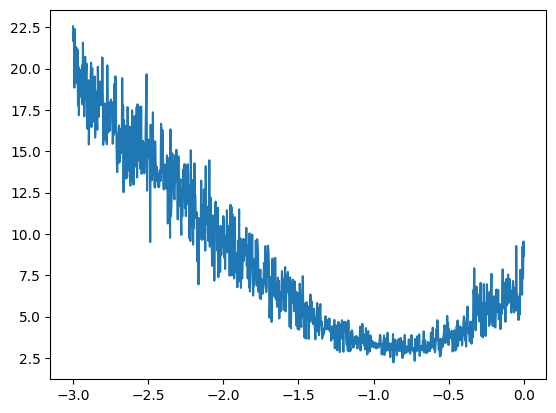

In [ ]:
plt.plot(lr_i, loss_i)

In [ ]:
ex = lr_i[loss_i.index(min(loss_i))].item()                 ## Learning Rate Exponent with lowest loss
lr = 10 ** ex                                                    ## Learning Rate with lowest loss
ex, lr

(-0.8678678870201111, 0.13556017255477787)

In [ ]:
logits.max(1), Y[ix]           ## Maximum of logits along the 1st dimension

(torch.return_types.max(
 values=tensor([10.9891,  6.7840, 10.2051,  7.4666, 17.2297, 15.2522,  9.9125,  9.5293,
          7.9958,  3.8270,  7.1025,  8.1759,  7.3969,  9.4433, 17.3797, 12.0095,
         11.4276, 10.1363, 10.3566,  8.9914,  9.9192,  6.6837,  9.0267,  8.1582,
          7.4264,  9.9125, 12.3367, 15.1481,  7.9596,  7.7097,  9.9125,  5.0110],
        grad_fn=<MaxBackward0>),
 indices=tensor([12, 14, 12, 12, 12, 12, 14, 12, 15, 12, 12, 12, 26, 12, 12, 12,  4, 18,
         12, 12, 12,  6, 12, 14, 11, 14, 12, 12, 12, 15, 14, 17])),
 tensor([25,  1,  9,  0, 13,  9, 12, 26,  3,  0, 14, 12, 19, 18, 19, 24, 25,  0,
         13, 15,  0, 14,  8, 14,  1,  1,  1,  5, 18,  1,  1, 12]))

# Inference

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * BLOCK_SIZE                      # initialize with all "..."
    while True:
      emb = C[torch.tensor([context])]              # (1, block_size, d). Embedding the current context from the embedding table C
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]                  # Shifting the context window
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
kayanniee.
mad.
rylle.
emmadiendraeg.
adee.
daeli.
jemi.
jenleigh.
van.
nar.
kateloh.
kalin.
shubergahimie.
trick.
welle.
joseus.
kunzey.
dariyah.
faeh.
